In [1]:
!python --version

Python 3.10.12


In [2]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [3]:
import keras
keras.__version__

'2.12.0'

In [4]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [ ]:
dir_ = Path('/content/drive/MyDrive/캡스톤/품종 딥러닝/크롤링/강아지')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/캡스톤/품종 딥러니...,Bichon
1,/content/drive/MyDrive/캡스톤/품종 딥러니...,Retriever
2,/content/drive/MyDrive/캡스톤/품종 딥러니...,Shih Tzu
3,/content/drive/MyDrive/캡스톤/품종 딥러니...,Beagle
4,/content/drive/MyDrive/캡스톤/품종 딥러니...,Bulldog


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 4800

Number of different labels: 16

Labels: ['Bichon' 'Retriever' 'Shih Tzu' 'Beagle' 'Bulldog' 'Pomeranian'
 'Welsh corgi' 'Poodle' 'Dachshund' 'Maltese' 'Yorkshire terrier' 'etc'
 'Chihuahua' 'Shiba dog' 'Border collie' 'Jindo dog']


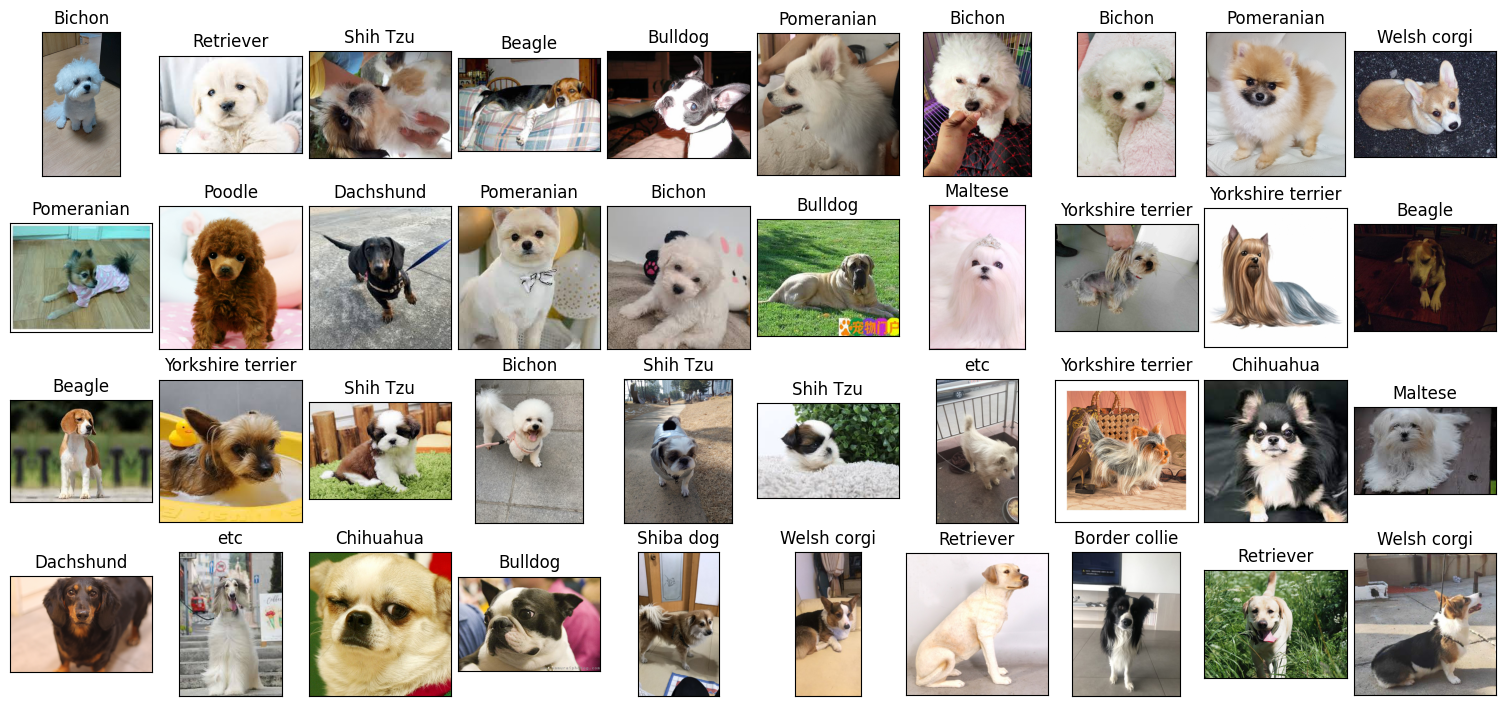

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

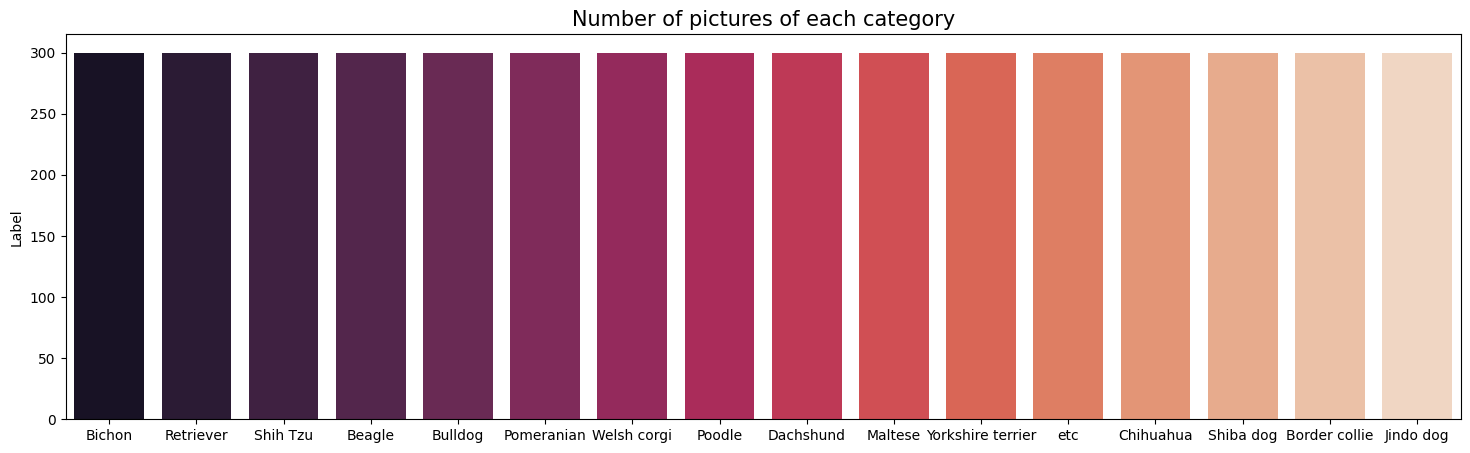

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(18,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=42)
train_df.shape,test_df.shape

((4320, 2), (480, 2))

In [ ]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
models = {
     "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
     "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0}
     "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
     "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
     "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
     "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
     "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
     "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
     "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
     "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
     "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
     "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
     "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(16, activation='softmax')(x)
    # 라벨 개수가 16개이기 때문에 Dencs도 16로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 3888 validated image filenames belonging to 16 classes.
Found 432 validated image filenames belonging to 16 classes.
Found 480 validated image filenames belonging to 16 classes.


9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 1043.7 sec


In [ ]:
# test데이터로 모델 성능 예측
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

15/15 [==============================] - 100s 7s/step
**MobileNetV2 has a 89.79% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,MobileNetV2,0.9074,0.8979,1043.7


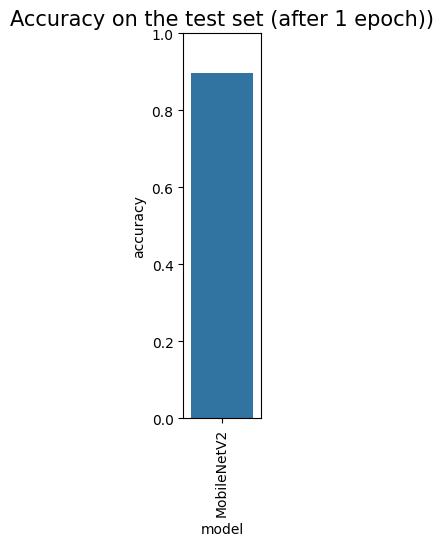

In [ ]:
plt.figure(figsize = (1,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

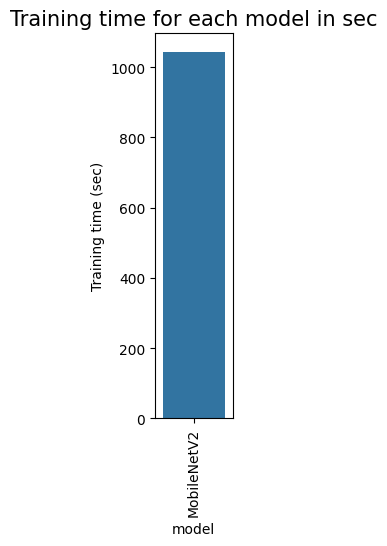

In [ ]:
plt.figure(figsize = (1,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 좋은 효율을 내는 모델 성능확인 (MobileNetV2)
train_df,test_df = train_test_split(df, test_size=0.1, random_state=20)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.MobileNetV2)
history = model.fit(train_images,validation_data=val_images,epochs=5)
model.save('/content/drive/MyDrive/캡스톤/품종 딥러닝/dog_model.h5')

Found 3888 validated image filenames belonging to 16 classes.
Found 432 validated image filenames belonging to 16 classes.
Found 480 validated image filenames belonging to 16 classes.
Epoch 1/5
122/122 [==============================] - 58s 436ms/step - loss: 0.6958 - accuracy: 0.7919 - val_loss: 0.3209 - val_accuracy: 0.9028
Epoch 2/5
122/122 [==============================] - 52s 425ms/step - loss: 0.2219 - accuracy: 0.9298 - val_loss: 0.2837 - val_accuracy: 0.9259
Epoch 3/5
122/122 [==============================] - 53s 432ms/step - loss: 0.1361 - accuracy: 0.9540 - val_loss: 0.2779 - val_accuracy: 0.9213
Epoch 4/5
122/122 [==============================] - 53s 431ms/step - loss: 0.0774 - accuracy: 0.9779 - val_loss: 0.3125 - val_accuracy: 0.9120
Epoch 5/5
122/122 [==============================] - 53s 435ms/step - loss: 0.0526 - accuracy: 0.9838 - val_loss: 0.3209 - val_accuracy: 0.9282


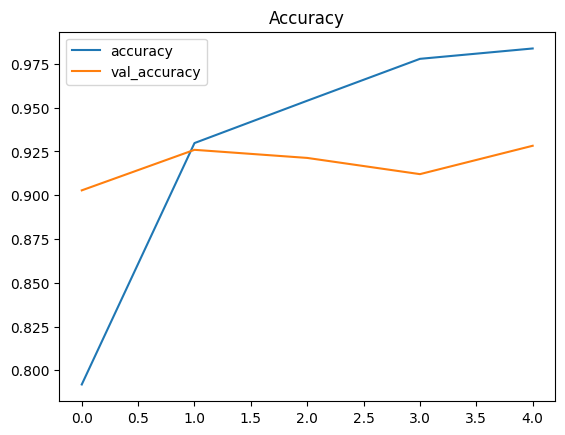

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

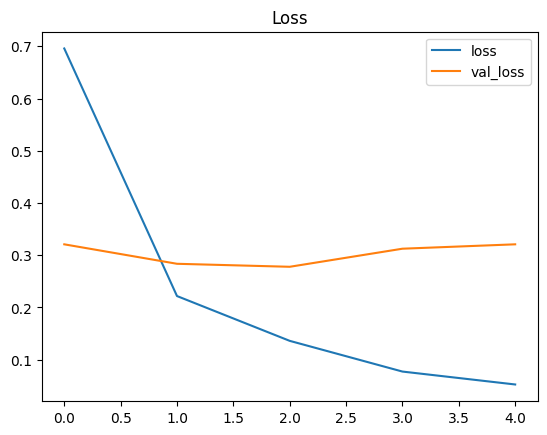

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

15/15 [==============================] - 7s 393ms/step
Accuracy on the test set: 92.08%


In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                   precision    recall  f1-score   support

           Beagle       1.00      1.00      1.00        28
           Bichon       0.83      0.71      0.77        21
    Border collie       0.94      0.97      0.95        31
          Bulldog       0.95      0.97      0.96        37
        Chihuahua       0.94      0.94      0.94        35
        Dachshund       1.00      0.94      0.97        32
        Jindo dog       0.96      0.92      0.94        24
          Maltese       0.85      0.88      0.86        25
       Pomeranian       0.91      0.80      0.85        25
           Poodle       0.88      0.97      0.92        30
        Retriever       0.91      0.97      0.94        30
        Shiba dog       0.93      0.90      0.91        29
         Shih Tzu       0.93      0.97      0.95        38
      Welsh corgi       0.90      0.97      0.93        36
Yorkshire terrier       0.91      0.97      0.94        30
              etc       0.88      0.72      0.79       

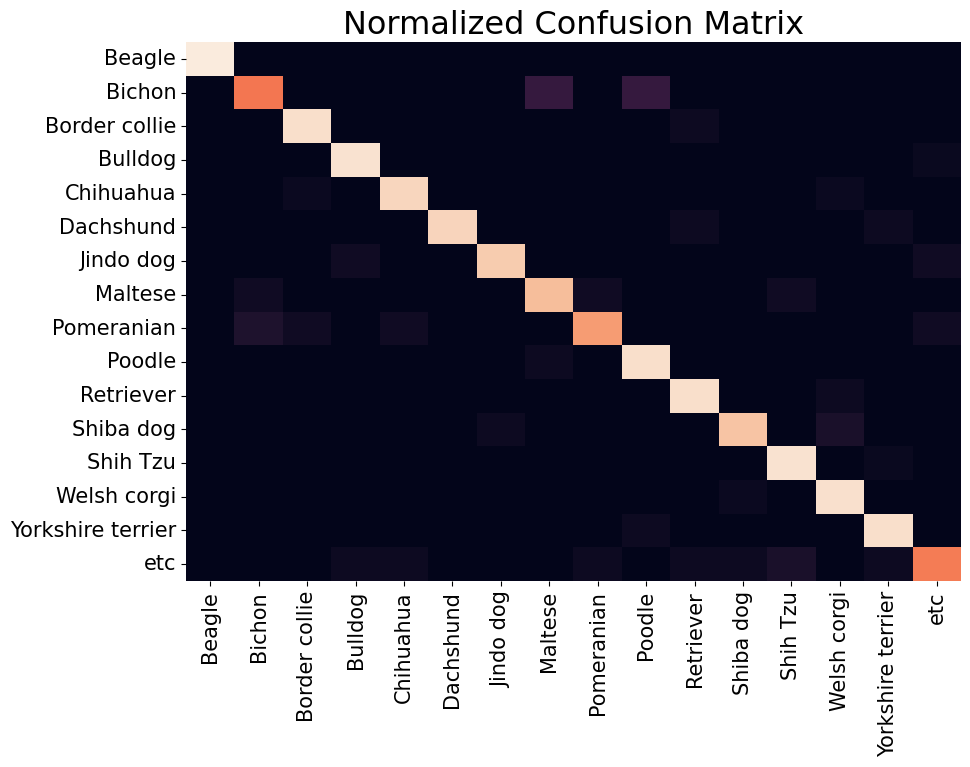

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

번호를 입력하세요 : 1
1/1 [==============================] - 2s 2s/step
예측률 : 99.99%
Class prediction = Retriever


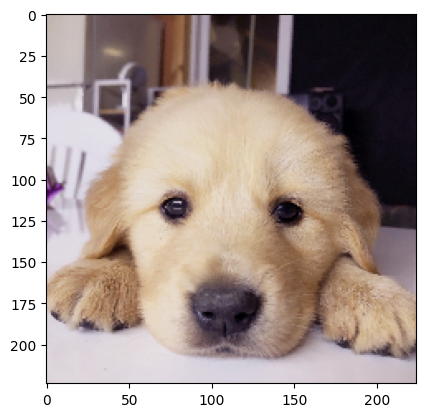

In [ ]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

class_dictionary = {'Beagle':0, 'Bichon':1, 'Border collie':2, 'Bulldog':3, 'Chihuahua':4, 'Dachshund':5,
 'Jindo dog':6, 'Maltese':7, 'Pomeranian':8, 'Poodle':9, 'Retriever':10, 'Shiba dog':11,
 'Shih Tzu':12, 'Welsh corgi':13, 'Yorkshire terrier':14, 'etc':15}

IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 0~479번까지
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
print(f"예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    print(f"Class prediction = {x}")
    break

In [ ]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.